In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# from MMDBalancing import MMDBalancing as MMDB
# from OptimalTransportBalancing import OptimalTransportBalancing as OTB
# from NeuralAdversarialBalancing import NeuralAdversarialBalancing as NAB
%matplotlib inline
import pandas as pd


# utils
from utils_balancing import *

In [2]:
n = 5000
m = 5000
d = 1
r = lambda x:(x-3).square() + (x>-2)*(x+3).square() +x.abs()
#r = lambda x:x.square()
def get_data(n = 500,m = 500, r = r, d = d):
    def pi(x):
        return torch.sin(x)+ 2*torch.rand(x.shape)-1
    def pi_ring(x):
        return torch.sin(x)+ 1*torch.rand(x.shape)-0.5
    
    
    xi = torch.normal(mean = -1, std = 2, size = (n,d))
    xi_ring = torch.zeros(size = (m,d))
    for i in range(m):
        if torch.rand(1).item()>0.3:
            xi_ring[i,0] = torch.normal(mean = -4, std = 2, size = (1,)).item()
        else:
            xi_ring[i,0] = torch.normal(mean = 3, std = 0.2, size = (1,)).item()
    w = torch.ones(n)
    w_ring = torch.ones(m)
    
    
    
    
    xi_natural = torch.cat((xi, pi(xi)),axis = 1)
    xi_ring_natural = torch.cat((xi_ring, pi_ring(xi_ring)), axis = 1)
    Z =xi_natural[:,0]+xi_natural[:,1] + torch.rand((n,)) 
    Z_ring =xi_ring_natural[:,0]+xi_ring_natural[:,1]+torch.rand((m,))
    R = r(Z)
    return xi_natural,xi_ring_natural,R,Z,Z_ring
xi_natural, xi_ring_natural_ref,R,Z,Z_ring = get_data(n = 5000, m = 5000)

## Viz of State-action measures

In [3]:
def viz(xi_natural):
    plt.hist2d(xi_natural[:,0].detach().numpy(), xi_natural[:,1].detach().numpy(),cmap = "binary", bins = 30)

Text(0.5, 1.0, 'Source state-action distribution: xi_natural')

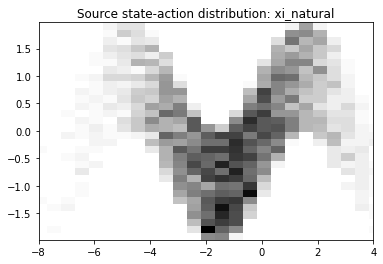

In [4]:
viz(xi_natural)
plt.xlim([-8,4])
plt.title("Source state-action distribution: xi_natural")

Text(0.5, 1.0, 'Target state-action distribution: xi_ring_natural')

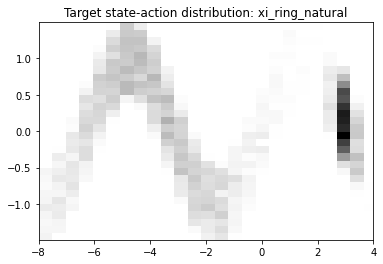

In [5]:
viz(xi_ring_natural_ref)
plt.xlim([-8,4])
plt.title("Target state-action distribution: xi_ring_natural")

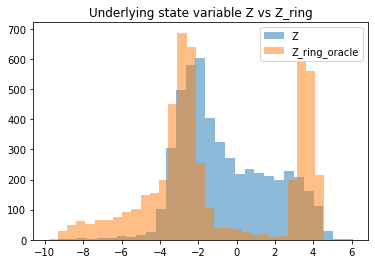

In [6]:
plt.hist(Z.detach().numpy().reshape(len(Z),), bins = 30, alpha = 0.5, label = "Z")
plt.hist(Z_ring.detach().numpy().reshape(len(Z),), bins = 30, alpha = 0.5, label = "Z_ring_oracle")
plt.title("Underlying state variable Z vs Z_ring")
plt.legend()

## Reference value

In [7]:
xi_natural, xi_ring_natural,R,Z,Z_ring = get_data(n = 50000, m = 50000)
ref = r(Z_ring).mean()
print(ref)

tensor(49.0964)


### Re-generate data set with $n=m=500$.

In [8]:
n = 500
m = 500
xi_natural, xi_ring_natural,R,Z,Z_ring = get_data(n = n, m = m, r = r)

# GIPWE: DE and DRE

1. Data splitting (K-folds with K = 3)

In [9]:
def get_split_ind(n,K = 3):
    I_n = torch.arange(n, dtype = float)
    
    rand_ind_n = torch.multinomial(I_n,len(I_n),replacement = False)
    num_folds_n = int(n/K)
    Ind = []
    for i in range(K):
        if (i+1)*num_folds_n <= n:
            Ind.append(list(rand_ind_n[i*num_folds_n:(i+1)*num_folds_n].detach().numpy()))
        else:
            Ind.append(list(rand_ind_n[i*num_folds_n:].detach().numpy()))
    
    Ind_split = []
    for i in range(K):
        list_n = []
        for j in range(n):
            if j >= i*num_folds_n and j < (i+1)*num_folds_n:
                pass
            else:
                list_n.append(rand_ind_n[j].item())
            
        Ind_split.append(list_n)
    return Ind_split,Ind

In [10]:
K = 3
Ind_out, Ind_in = get_split_ind(n,K)

2. Get GIPW weights

In [11]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [12]:
XGB = xgb.XGBRegressor(gamma = 5e0)
RF = RandomForestRegressor(n_estimators = 20, min_samples_split = 20)
LR = LogisticRegression()
def get_GIPW_weights(model):
    eta = np.zeros(n)
    for k in range(K):
        print("Fold {}:".format(k))
        SGIPW = Shallow_GIPW(xi_natural[Ind_out[k],:], xi_ring_natural)
        
        SGIPW.train(model,xi = np.array(xi_natural[Ind_in[k],:]),log=True)
        eta[Ind_in[k]] = SGIPW.weights*(SGIPW.weights>0)
    return eta

print("XGB:")
eta_XGB = get_GIPW_weights(XGB)
print("\n")
print("RF:")
eta_RF = get_GIPW_weights(RF)
print("\n")
print("LR:")
eta_LR = get_GIPW_weights(LR)

XGB:
Fold 0:
train loss: 0.13692166515513973
test loss: 0.16649290168029232
Fold 1:
train loss: 0.2045988528567467
test loss: 0.2029622747522847
Fold 2:
train loss: 0.13737753769352531
test loss: 0.16122431300247572


RF:
Fold 0:
train loss: 0.07185604436207664
test loss: 0.14369098009439074
Fold 1:
train loss: 0.08980558674238688
test loss: 0.15376506103949591
Fold 2:
train loss: 0.08163847043951841
test loss: 0.15359285775358578


LR:
Fold 0:
train loss: 0.43373493975903615
test loss: 0.4002998500749625
Fold 1:
train loss: 0.3313253012048193
test loss: 0.3613193403298351
Fold 2:
train loss: 0.4397590361445783
test loss: 0.4482758620689655


In [13]:
def Viz_Z(eta):
    plt.hist(Z.detach().numpy().reshape(len(Z),),weights=eta, bins = 30, alpha = 0.5, label = "re-weighted Z")
    plt.hist(Z_ring.detach().numpy().reshape(len(Z),), bins = 30, alpha = 0.5, label = "Z_ring_oracle")
    plt.title("Underlying state variable Z vs Z_ring")
    plt.legend()

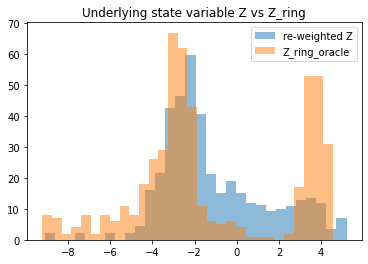

In [14]:
Viz_Z(eta_XGB)

In [15]:
def Viz_natural(eta, bins = 30):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,4), sharey = True)
    fig.suptitle('Comparison with oracle state-action distribution')
    ax1.hist2d(xi_natural[:,0].detach().numpy(), xi_natural[:,1].detach().numpy(), weights = eta,cmap = "binary", bins = bins)
    ax2.hist2d(xi_ring_natural_ref[:,0].detach().numpy(), xi_ring_natural_ref[:,1].detach().numpy(),cmap = "binary", bins = bins)
    ax1.set_xlim([-8, 4])
    ax2.set_xlim([-8, 4])
    ax1.title.set_text('re-weighted')
    ax2.title.set_text('ref')

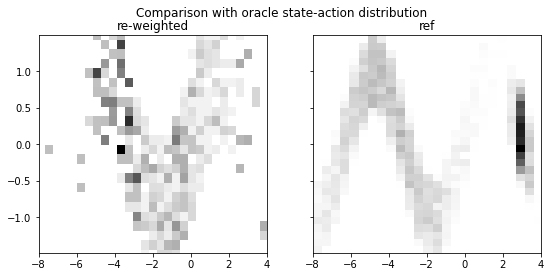

In [16]:
Viz_natural(eta_XGB)

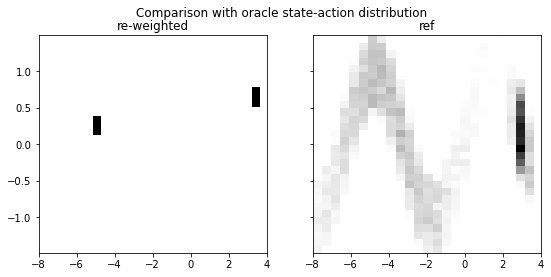

In [17]:
Viz_natural(eta_RF)

3. Get balancing weights

In [18]:
# OT
OTB = OptimalTransportBalancing()
eta_OT = OTB.get_weights(xi_natural,xi_ring_natural)
eta_OT = eta_OT.detach().numpy()

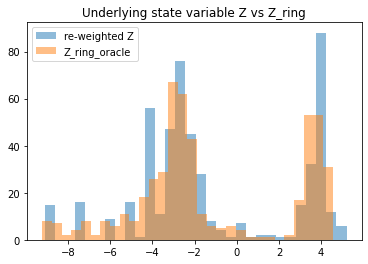

In [19]:
Viz_Z(eta_OT)

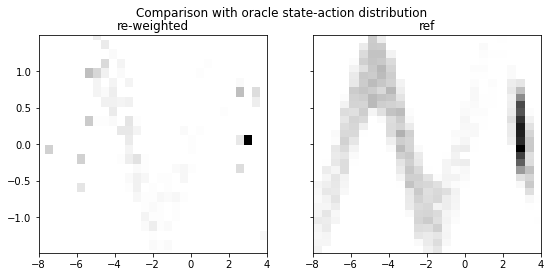

In [20]:
Viz_natural(eta_OT)

In [21]:
# MMD weights
lambda_RKHS = 1e2
lambda_l2 = 1e-3
MMDB = MMDBalancing(xi_natural,xi_ring_natural,sigma = 5e-1,D = 2000)
eta_MMD = MMDB.get_weights(lambda_RKHS = lambda_RKHS, lambda_l2 = lambda_l2)
eta_MMD = eta_MMD*(eta_MMD>0)
eta_MMD = eta_MMD.to("cpu").detach().numpy()

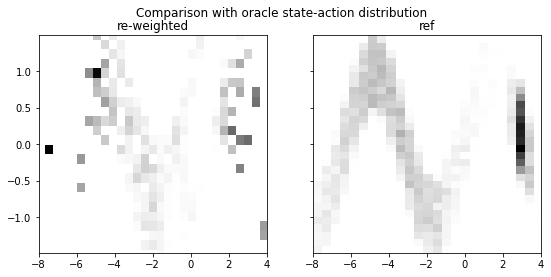

In [22]:
Viz_natural(eta_MMD)

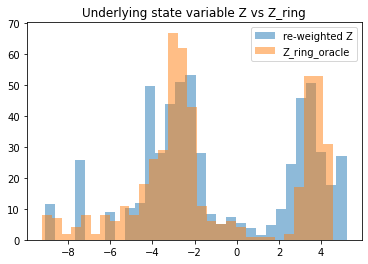

In [23]:
Viz_Z(eta_MMD)

In [24]:
eta_MMD.mean()

1.1256951523380017

In [25]:
# Neural Adversarial Balancing
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim = 1, num_nodes = 32):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            #nn.Linear(num_nodes, num_nodes),
            #nn.ReLU(),
            # # #nn.Dropout(0.3),
            # # nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        target = self.linear_relu_stack(x)
        return target

In [26]:
AB = Adversarial_Balancing(xi_natural,xi_ring_natural)
num_nodes_IPM = 32
model_IPM = NeuralNetwork(input_dim = d*2,num_nodes = 2*num_nodes_IPM).to(AB.dev)
model_reweighting = NeuralNetwork(input_dim = d*2, num_nodes = num_nodes_IPM).to(AB.dev)
learning_rate = 1e-3
optimizer_IPM = torch.optim.Adam(model_IPM.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
optimizer_reweighting = torch.optim.Adam(model_reweighting.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)

In [27]:
epochs = 50
loss_trace = []
for t in tqdm(range(epochs)):
    #print(f"Epoch {t+1}\n-------------------------------")
    current_test_loss = AB.train_loop(model_IPM = model_IPM,
                                      model_reweighting = model_reweighting,
                                      optimizer_IPM = optimizer_IPM,
                                      optimizer_reweighting = optimizer_reweighting,
                                      IPM_steps = 1,
                                      reweight_steps = 1,
                                      lambda_l2_weight = 5e-2,
                                      lambda_l2_IPM = 1e-2,
                                      lambda_l1_IPM = 1e-2,
                                     )
    loss_trace.append(current_test_loss.to("cpu").detach().numpy())
print("Done!")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.89it/s]

Done!


Text(0.5, 1.0, 'Gaming curve between the two players')

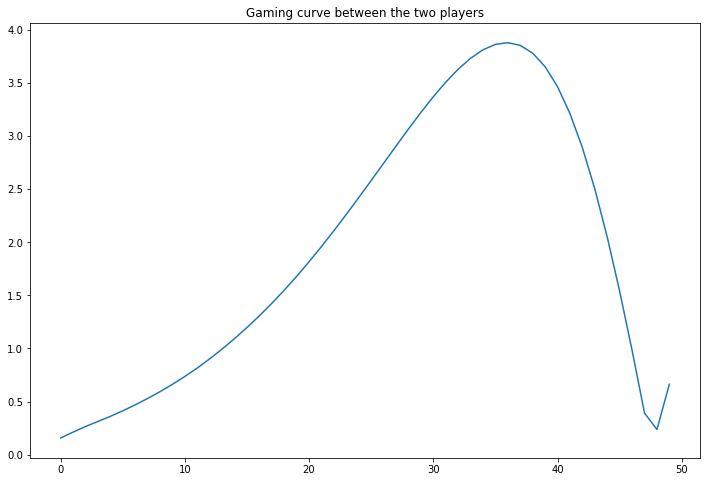

In [28]:
plt.figure(figsize = (12,8))
plt.plot(np.array(loss_trace))
plt.title("Gaming curve between the two players")

In [29]:
weights = model_reweighting(xi_natural.to("cuda:0"))
#weights /=weights.mean()
eta_NAB = weights.to("cpu").detach().numpy().reshape((len(weights,)))

In [30]:
np.mean(eta_NAB)

1.5898535

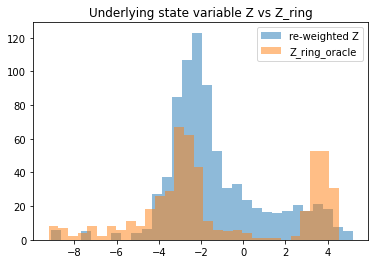

In [31]:
Viz_Z(eta_NAB)

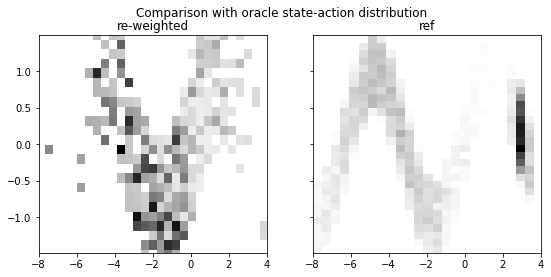

In [32]:
Viz_natural(eta_NAB)

4. Get $r^{\natural}$ estimation with the same K-fold splitting

In [33]:
from sklearn.linear_model import LinearRegression
RF_R = RandomForestRegressor(n_estimators = 20, min_samples_split = 5)
#model_r = RF_R
model_r = LinearRegression()


In [34]:
def get_r_estimation(model, K = 3):
    r_hat = np.zeros(n)
    r_hat_ring = np.zeros(m)
    for k in range(K):
        SGIPW = Shallow_GIPW(xi_natural[Ind_out[k],:], xi_ring_natural)
        model_k = model
        model_k.fit(xi_natural[Ind_out[k],:].detach().numpy(), R[Ind_out[k]].detach().numpy())
        
        r_hat[Ind_in[k]] = model_k.predict(xi_natural[Ind_in[k]].detach().numpy())
        r_hat_ring += model_k.predict(xi_ring_natural.detach().numpy())
    r_hat_ring /= K
        
    return r_hat, r_hat_ring

In [35]:
r_hat,r_hat_ring = get_r_estimation(model_r)

In [36]:
r_hat_ring.mean()

32.51861779149374

## Estimators

In [37]:
def get_DE(eta, R = R, ref= ref):
    try:
        eta = torch.from_numpy(eta)
    except:
        pass
    pred = (eta*R).mean().item()
    error  = torch.abs(pred - ref).item()
    return pred, error 
def get_DRE(eta,r_hat, r_hat_ring, R = R, ref = ref):
    try:
        eta = torch.from_numpy(eta)
        r_hat = torch.from_numpy(r_hat)
    except:
        pass
    pred = (eta*(R -r_hat)).mean() + r_hat_ring.mean()
    error  = torch.abs(pred - ref).item()
    return pred.item(), error 
    
    
    
    

In [38]:
#pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
table_bad_reg = pd.DataFrame([[get_DE(eta_OT)[1],get_DRE(eta_OT,r_hat,r_hat_ring)[1]],[get_DE(eta_MMD)[1],get_DRE(eta_MMD,r_hat,r_hat_ring)[1]],\
                          [get_DE(eta_NAB)[1],get_DRE(eta_NAB,r_hat,r_hat_ring)[1]],\
                         [get_DE(eta_RF)[1],get_DRE(eta_RF,r_hat,r_hat_ring)[1]],[get_DE(eta_XGB)[1],get_DRE(eta_XGB,r_hat,r_hat_ring)[1]],\
                          [get_DE(eta_LR)[1],get_DRE(eta_LR,r_hat,r_hat_ring)[1]],[None, torch.abs(r_hat_ring.mean()-ref).item()]],\
                        columns = ("DE","DRE"), index = ("OT", "MMD","NAB", "GIPW-RF","GIPW-XGB","GIPW-LR","G-computation"))

## Bad regression model: Linear regression

In [39]:
table_bad_reg

,DE,DRE
OT,0.13,0.60
MMD,5.51,2.70
NAB,5.76,11.07
GIPW-RF,34136808.00,17689203.84
GIPW-XGB,20.10,13.69
GIPW-LR,17.25,15.80
G-computation,NaN,16.58


## Good regression model: XGBoosting

In [40]:
XGB_R = xgb.XGBRegressor(n_estimators = 20, gamma = 1e-0)
model_r = XGB_R
r_hat,r_hat_ring = get_r_estimation(model_r)

In [41]:
pd.set_option("display.precision", 2)
table_good_reg = pd.DataFrame([[get_DE(eta_OT)[1],get_DRE(eta_OT,r_hat,r_hat_ring)[1]],[get_DE(eta_MMD)[1],get_DRE(eta_MMD,r_hat,r_hat_ring)[1]],\
                          [get_DE(eta_NAB)[1],get_DRE(eta_NAB,r_hat,r_hat_ring)[1]],\
                         [get_DE(eta_RF)[1],get_DRE(eta_RF,r_hat,r_hat_ring)[1]],[get_DE(eta_XGB)[1],get_DRE(eta_XGB,r_hat,r_hat_ring)[1]],\
                          [get_DE(eta_LR)[1],get_DRE(eta_LR,r_hat,r_hat_ring)[1]],[None, torch.abs(r_hat_ring.mean()-ref).item()]],\
                        columns = ("DE","DRE"), index = ("OT", "MMD","NAB", "GIPW-RF","GIPW-XGB","GIPW-LR","G-computation"))


In [42]:
table_good_reg

,DE,DRE
OT,0.13,2.87
MMD,5.51,1.60
NAB,5.76,1.71
GIPW-RF,34136808.00,2951371.68
GIPW-XGB,20.10,1.24
GIPW-LR,17.25,0.94
G-computation,NaN,0.89


# 100 independe simulations

In [43]:
from static_simulation import static_simulation

In [58]:
# results_bad = np.zeros((100,7,2))
# results_good = np.zeros((100,7,2))
# for i_sim in tqdm(range(100)):
#     table_bad, table_good = static_simulation()
#     results_bad[i_sim] = table_bad.to_numpy()
#     results_good[i_sim] = table_good.to_numpy()
# 
# ## time spent:  19:05<00:00, 11.46s/it
# 
# final_results_bad = [["None" for j in range(2)]for i in range(7)]
# final_results_good = [["None" for j in range(2)]for i in range(7)]
# 
# clip = lambda x: '%.2f' % x
# 
# for i in range(7):
#     for j in range(2):
#         list_temp = []
#         for i_sim in range(100):
#             list_temp.append(results_bad[i_sim,i,j])
#         mean = np.mean(list_temp)
#         sd = np.std(list_temp)
#         
#         mean = clip(mean)
#         sd = clip(sd)
#         
#         result = str(mean)+u"\u00B1"+str(sd)
#         final_results_bad[i][j] = result
#         
#         list_temp = []
#         for i_sim in range(100):
#             list_temp.append(results_good[i_sim,i,j])
#         mean = np.mean(list_temp)
#         sd = np.std(list_temp)
#         
#         mean = clip(mean)
#         sd = clip(sd)
#         
#         result = str(mean)+u"\u00B1"+str(sd)
#         final_results_good[i][j] = result
#         
# 
# table_good_final = pd.DataFrame(final_results_good,
#                         columns = ("DE","DRE"), index = ("OT", "MMD","NAB", "GIPW-RF","GIPW-XGB","GIPW-LR","G-computation"))
# 
# table_bad_final = pd.DataFrame(final_results_bad,
#                         columns = ("DE","DRE"), index = ("OT", "MMD","NAB", "GIPW-RF","GIPW-XGB","GIPW-LR","G-computation"))
# 
# 

In [59]:
#table_bad_final.to_csv("static_table_bad.csv")
#table_good_final.to_csv("static_table_good.csv")

In [60]:
#table_bad_final

In [61]:
#table_good_final

In [55]:
table_bad_final_read = pd.read_csv("static_table_bad.csv",index_col = 0)
table_good_final_read = pd.read_csv("static_table_good.csv",index_col = 0)

In [56]:
table_bad_final_read

,DE,DRE
OT,2.06±1.60,1.94±1.60
MMD,2.57±1.78,1.92±1.49
NAB,8.64±6.92,15.98±0.76
GIPW-RF,40340046.98±40816418.79,15289431.04±16883824.59
GIPW-XGB,21.26±2.54,13.99±1.08
GIPW-LR,15.16±3.22,15.78±0.85
G-computation,nan±nan,16.24±0.74


In [57]:
table_good_final_read

,DE,DRE
OT,2.06±1.60,2.14±1.82
MMD,2.57±1.78,2.00±1.69
NAB,8.64±6.92,2.17±1.59
GIPW-RF,40340046.98±40816418.79,2836504.76±3657214.00
GIPW-XGB,21.26±2.54,2.26±1.63
GIPW-LR,15.16±3.22,2.35±1.67
G-computation,nan±nan,2.46±1.71
